# Project 3: SAMSum Dialogue Summarization — BERT2BERT (GPU T4)

This notebook fine-tunes an encoder–decoder model (BERT2BERT) on the SAMSum dataset and evaluates with ROUGE.



In [ ]:
# Pip install (Jupyter uses: !pip ...). In .py script use subprocess:
import subprocess
import sys
subprocess.check_call([
    sys.executable, "-m", "pip", "-q", "install", "-U",
    "transformers", "datasets", "evaluate", "rouge-score", "accelerate", "safetensors"
])

import os, random, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from datasets import load_dataset
import transformers, datasets, evaluate

from transformers import (
    AutoTokenizer,
    EncoderDecoderModel,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    GenerationConfig
)

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Torch:", torch.__version__)
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Enable GPU: Runtime → Change runtime type → T4 GPU")

Transformers: 5.1.0
Datasets: 4.5.0
Torch: 2.9.0+cu128
Device: cuda
GPU: Tesla T4


In [ ]:
dataset = load_dataset("knkarthick/samsum")
print(dataset)
print("Train:", len(dataset["train"]), "Val:", len(dataset["validation"]), "Test:", len(dataset["test"]))

print("\nSample dialogue:\n", dataset["train"][0]["dialogue"][:500])
print("\nReference summary:\n", dataset["train"][0]["summary"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14731 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
})
Train: 14731 Val: 818 Test: 819

Sample dialogue:
 Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Reference summary:
 Amanda baked cookies and will bring Jerry some tomorrow.


In [ ]:
rouge = evaluate.load("rouge")

def lead3_baseline(dialogue: str) -> str:
    lines = [l.strip() for l in dialogue.split("\n") if l.strip()]
    return " ".join(lines[:3])

N_BASE = 500
val_sample = dataset["validation"].select(range(N_BASE))

baseline_preds = [lead3_baseline(x["dialogue"]) for x in val_sample]
baseline_refs  = [x["summary"] for x in val_sample]

baseline_scores = rouge.compute(predictions=baseline_preds, references=baseline_refs, use_stemmer=True)
baseline_scores = {k: round(v*100, 2) for k, v in baseline_scores.items()}
print("Baseline ROUGE (Lead-3) on", N_BASE, "val samples:", baseline_scores)


Baseline ROUGE (Lead-3) on 500 val samples: {'rouge1': np.float64(32.35), 'rouge2': np.float64(9.83), 'rougeL': np.float64(25.1), 'rougeLsum': np.float64(25.18)}


In [ ]:
MODEL_NAME = "bert-base-uncased"
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 64

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(batch):
    model_inputs = tokenizer(
        batch["dialogue"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length",
    )

    targets = tokenizer(
        text_target=batch["summary"],   # ✅ modern approach
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length",
    )

    labels = targets["input_ids"]
    labels = [[(t if t != tokenizer.pad_token_id else -100) for t in seq] for seq in labels]
    model_inputs["labels"] = labels
    return model_inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,  # RAM-safe
    desc="Tokenizing",
)

print("✓ Tokenization complete")
print(tokenized_dataset)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing:   0%|          | 0/14731 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/818 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/819 [00:00<?, ? examples/s]

✓ Tokenization complete
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14731
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
})


In [ ]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(MODEL_NAME, MODEL_NAME)

# Required token ids for encoder-decoder generation
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.bos_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size

# ✅ Use generation_config (new versions)
model.generation_config = GenerationConfig(
    max_new_tokens=MAX_TARGET_LENGTH,   # ✅ use max_new_tokens ONLY
    num_beams=4,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    early_stopping=True,
    decoder_start_token_id=tokenizer.cls_token_id,
    bos_token_id=tokenizer.cls_token_id,
    eos_token_id=tokenizer.sep_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

model = model.to(device)

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

print("✓ Model ready on", device)
print("decoder_start_token_id:", model.config.decoder_start_token_id)
print("generation_config.decoder_start_token_id:", model.generation_config.decoder_start_token_id)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/202 [00:00<?, ?it/s]

BertLMHeadModel LOAD REPORT from: bert-base-uncased
Key                                                                | Status     | 
-------------------------------------------------------------------+------------+-
cls.seq_relationship.weight                                        | UNEXPECTED | 
bert.pooler.dense.bias                                             | UNEXPECTED | 
bert.pooler.dense.weight                                           | UNEXPECTED | 
cls.seq_relationship.bias                                          | UNEXPECTED | 
bert.encoder.layer.{0...11}.crossattention.self.value.weight       | MISSING    | 
bert.encoder.layer.{0...11}.crossattention.self.key.bias           | MISSING    | 
bert.encoder.layer.{0...11}.crossattention.self.query.bias         | MISSING    | 
bert.encoder.layer.{0...11}.crossattention.self.query.weight       | MISSING    | 
bert.encoder.layer.{0...11}.crossattention.output.dense.weight     | MISSING    | 
bert.encoder.layer.{0...11}.crossat

✓ Model ready on cuda
decoder_start_token_id: 101
generation_config.decoder_start_token_id: 101


In [ ]:
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # preds can be tuple in some versions
    if isinstance(preds, tuple):
        preds = preds[0]

    preds = np.asarray(preds)
    labels = np.asarray(labels)

    # Clamp to valid token ID range to avoid OverflowError in tokenizer.decode
    vocab_size = tokenizer.vocab_size
    preds = np.clip(preds, 0, vocab_size - 1).astype(np.int64)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    labels = np.clip(labels, 0, vocab_size - 1).astype(np.int64)

    # Decode: pass as list of lists of Python ints for safest decode
    decoded_preds = tokenizer.batch_decode(
        preds.tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    decoded_labels = tokenizer.batch_decode(
        labels.tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=True
    )

    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    return {k: round(v*100, 4) for k, v in result.items()}

print("✓ Metrics ready (safe decode)")

✓ Metrics ready (safe decode)


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",

    eval_strategy="steps",
    eval_steps=500,

    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,

    learning_rate=5e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    max_grad_norm=1.0,

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,

    fp16=True,

    predict_with_generate=True,
    generation_num_beams=4,          # ✅ beams only; length comes from generation_config

    eval_accumulation_steps=8,

    logging_steps=100,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="rougeL",
    greater_is_better=True,

    seed=SEED
)

print("✓ Training arguments set")

✓ Training arguments set


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

gc.collect()
torch.cuda.empty_cache()

print("✓ Trainer initialized")

✓ Trainer initialized


In [ ]:
print("START TRAINING")
train_result = trainer.train()
print("✓ Training done")
print("Train metrics:", train_result.metrics)

START TRAINING


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
500,31.456245,3.712972,18.564700,3.428700,14.542100,14.536100
1000,23.539775,3.070472,29.438900,7.218500,23.053000,23.022800
1500,21.466831,2.868112,32.584000,9.493000,25.464000,25.475000
2000,18.097150,2.754578,35.398700,10.188400,27.262000,27.258600
2500,17.550797,2.704504,36.486400,10.780100,28.226100,28.209900


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['decoder.cls.predictions.decoder.weight', 'decoder.cls.predictions.decoder.bias'].


✓ Training done
Train metrics: {'train_runtime': 4373.9465, 'train_samples_per_second': 10.104, 'train_steps_per_second': 0.632, 'total_flos': 1.355518853125632e+16, 'train_loss': 24.819215280958762, 'epoch': 3.0}


In [ ]:
val_metrics = trainer.evaluate(tokenized_dataset["validation"])
test_metrics = trainer.evaluate(tokenized_dataset["test"])

print("Validation metrics:", val_metrics)
print("Test metrics:", test_metrics)

/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:445: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Validation metrics: {'eval_loss': 2.7045042514801025, 'eval_rouge1': 36.4864, 'eval_rouge2': 10.7801, 'eval_rougeL': 28.2261, 'eval_rougeLsum': 28.2099, 'eval_runtime': 273.2107, 'eval_samples_per_second': 2.994, 'eval_steps_per_second': 1.497, 'epoch': 3.0}
Test metrics: {'eval_loss': 2.7068424224853516, 'eval_rouge1': 36.1002, 'eval_rouge2': 10.705, 'eval_rougeL': 28.0473, 'eval_rougeLsum': 28.0411, 'eval_runtime': 253.6903, 'eval_samples_per_second': 3.228, 'eval_steps_per_second': 1.616, 'epoch': 3.0}


In [ ]:
SAVE_DIR = "./final_model_bert2bert_samsum"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("✓ Saved to:", SAVE_DIR)
print("Contents:", os.listdir(SAVE_DIR))

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✓ Saved to: ./final_model_bert2bert_samsum
Contents: ['config.json', 'model.safetensors', 'generation_config.json', 'tokenizer.json', 'tokenizer_config.json', 'training_args.bin']


In [ ]:
reloaded_tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
reloaded_model = EncoderDecoderModel.from_pretrained(SAVE_DIR).to(device)

# Keep same generation config
reloaded_model.generation_config = model.generation_config

def summarize(dialogue: str):
    inputs = reloaded_tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_INPUT_LENGTH,
        padding="max_length"
    ).to(device)

    output_ids = reloaded_model.generate(
        **inputs,
        max_new_tokens=MAX_TARGET_LENGTH,  # ✅ only this
        num_beams=4,
        no_repeat_ngram_size=3,
        length_penalty=2.0,
        early_stopping=True
    )
    return reloaded_tokenizer.decode(output_ids[0], skip_special_tokens=True)

for i in range(3):
    d = dataset["test"][i]["dialogue"]
    ref = dataset["test"][i]["summary"]
    pred = summarize(d)

    print("\n" + "="*70)
    print("DIALOGUE:\n", d[:600], "..." if len(d) > 600 else "")
    print("\nREFERENCE:\n", ref)
    print("\nPREDICTION:\n", pred)


Loading weights:   0%|          | 0/521 [00:00<?, ?it/s]


DIALOGUE:
 Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye 

REFERENCE:
 Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

PREDICTION:
 amanda asked hannah about her phone number but she didn ' t.

DIALOGUE:
 Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric

         loss  grad_norm  learning_rate     epoch  step  eval_loss  \
30  17.326083  52.456680       0.000004  2.823242  2600        NaN   
31  17.355436  49.966698       0.000001  2.931849  2700        NaN   
32        NaN        NaN            NaN  3.000000  2763        NaN   
33        NaN        NaN            NaN  3.000000  2763   2.704504   
34        NaN        NaN            NaN  3.000000  2763   2.706842   

    eval_rouge1  eval_rouge2  eval_rougeL  eval_rougeLsum  eval_runtime  \
30          NaN          NaN          NaN             NaN           NaN   
31          NaN          NaN          NaN             NaN           NaN   
32          NaN          NaN          NaN             NaN           NaN   
33      36.4864      10.7801      28.2261         28.2099      273.2107   
34      36.1002      10.7050      28.0473         28.0411      253.6903   

    eval_samples_per_second  eval_steps_per_second  train_runtime  \
30                      NaN                    NaN         

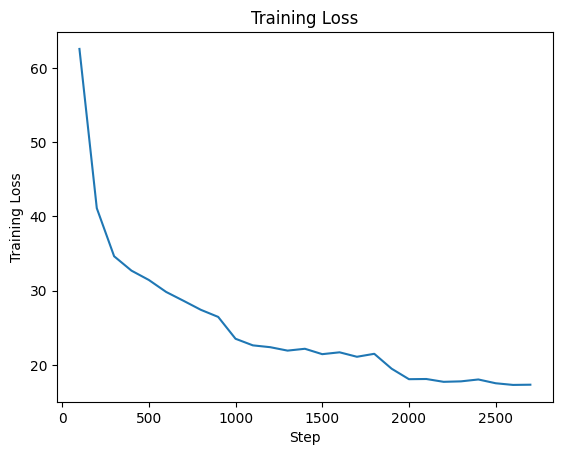

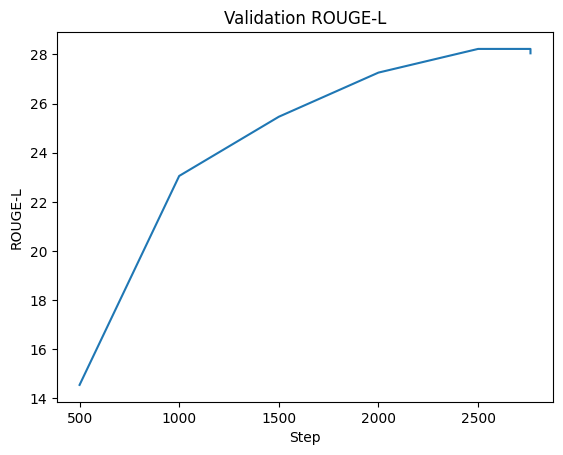

In [ ]:
logs = trainer.state.log_history
df = pd.DataFrame(logs)
print(df.tail())

if "loss" in df.columns:
    df_train = df.dropna(subset=["loss"])
    plt.figure()
    plt.plot(df_train["step"], df_train["loss"])
    plt.xlabel("Step")
    plt.ylabel("Training Loss")
    plt.title("Training Loss")
    plt.show()

if "eval_rougeL" in df.columns:
    df_eval = df.dropna(subset=["eval_rougeL"])
    plt.figure()
    plt.plot(df_eval["step"], df_eval["eval_rougeL"])
    plt.xlabel("Step")
    plt.ylabel("ROUGE-L")
    plt.title("Validation ROUGE-L")
    plt.show()
